# Milestone 3

In [1]:
# Install missing packages
#%pip install cpi

In [126]:
#we import all the necessary librairies here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from raceplotly.plots import barplot

from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf

import ast
from datetime import datetime
import cpi

import dash
from dash import dcc, html
from dash.dependencies import Input, Output


# # Make sure that we have the good rate for computing the inflation
# cpi.update()


In [3]:
#data paths
data_path = './data/'
cmu_path = data_path+'MovieSummaries/'
acl_persona_path = data_path+'ACL_personas_dump/personas/'

In [118]:
# color for data visualisation

# Single color graph
SING_COLOR = 'cornflowerblue'

# Comparison color graphs
COMP_COLOR1 = ['cornflowerblue', 'orange'] #use color_discrete_map when plotting
COMP_COLOR2 = px.colors.qualitative.Pastel #use color_discrete_sequence when plotting

# Multi color graph (not necessary comparison)
MULT_COLOR = px.colors.qualitative.T10 #use color_discrete_sequence when plotting

# Template for graph
TEMPLATE = 'seaborn'

## 1. Data cleaning and preprocessing

In this part we will import, clean and transform the data we will use for later analysis.

- We will first create a more complete movie dataset by merging the data from cmu with some useful data from imdb.
- Then, the dataset is cleaned and transformed to be used for later analysis.
- We perform the same cleaning for the character dataset.
- Once all the datasets are ready, we compute a fame score to quantisize the sucess of an actor. This a first version of the fame score that we will show as satisfying enough for the pre-analysis. It will be improved based on futur milestone with more complex computations.
- Finally, we load the dataset from ACL_personas_dump and merge it with the character one to get associate personas to each character.   

#### 1.1 Movie dataset

Let's first have a look at the cmu movie dataset more in details to see what we can do with it.

In [4]:
#Import the cmu movie dataset and print a sample of 5 random row in the dataset
cmu_movie_cols = ['wikiID',
                  'freebase_movID',
                  'movie_name',
                  'release_date',
                  'boxoffice',
                  'runtime',
                  'language',
                  'country',
                  'genre']

cmu_movies = pd.read_csv(cmu_path+'movie.metadata.tsv', sep='\t', names=cmu_movie_cols)
cmu_movies.sample(5)

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre
61712,31322912,/m/0gjc8g0,Hellas ohne Götter,1957,NaN,NaN,"{""/m/04306rv"": ""German Language""}","{""/m/03f2w"": ""German Democratic Republic""}","{""/m/02hmvc"": ""Short Film"", ""/m/0jtdp"": ""Docum..."
48979,5159792,/m/0d5kv_,The Caveman's Valentine,2001,687194.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."
54773,13869704,/m/03clr93,Donga Sachinollu,2008-04-25,NaN,NaN,"{""/m/09s02"": ""Telugu language""}","{""/m/03rk0"": ""India""}","{""/m/01z4y"": ""Comedy""}"
75705,21923306,/m/05p2v8s,The Dog,1993-01-20,NaN,3.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film""}"
36358,18991173,/m/04jbyrj,Herzog Blaubarts Burg,NaN,NaN,60.0,"{""/m/04306rv"": ""German Language""}","{""/m/082fr"": ""West Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [5]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          81741 non-null  int64  
 1   freebase_movID  81741 non-null  object 
 2   movie_name      81741 non-null  object 
 3   release_date    74839 non-null  object 
 4   boxoffice       8401 non-null   float64
 5   runtime         61291 non-null  float64
 6   language        81741 non-null  object 
 7   country         81741 non-null  object 
 8   genre           81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


The first thing we see here is that we do not have a lot of boxoffice data for the movies. However we need a way to asses the success of a movie for our analysis (we will later use this notion to compute a fame score for the actors).

To solve this issue we decided that we will use the imdb rating and number of votes as a proxy for the success and popularity of a movie.

In [6]:
# As the dataset is pretty big, we won't bother importing columns that we don't need later to save memory space
col_to_load = ['tconst','primaryTitle','startYear']
col_dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64'}

imdb_movies = pd.read_csv(data_path+'title_basics.tsv', usecols=col_to_load, sep='\t', na_values=['\\N'], 
                          dtype=col_dtype)
imdb_ratings= pd.read_csv(data_path+'title_ratings.tsv', sep='\t')

# As this dataset is a way for us to get the title of the rating dataset, we will drop all 
# the rows that have NaN values in the primaryTitle column.
imdb_movies.dropna(subset=['primaryTitle'], inplace=True)


Now let's combine the two to have a new dataset containing the title of the movie and its rating.

In [7]:
imdb_movies_ratings = imdb_movies.merge(imdb_ratings,how='inner',on='tconst')
imdb_movies_ratings.sample(5)

,tconst,primaryTitle,startYear,averageRating,numVotes
396460,tt0807950,Harry,2005,8.0,15
330212,tt0641605,Little Girl Lost,1973,7.9,131
756145,tt1616074,Million Dollar Smile,2010,8.1,168
830371,tt19284334,Buried Secrets of Mount Cook,2022,7.2,5
730702,tt1543544,My Angel My Hero,2011,6.9,9


Now that we have a dataset with the title of the movie and its rating, we can clean the duplicates and the movies with no rating.

In [8]:
imdb_movies_ratings.primaryTitle = imdb_movies_ratings.primaryTitle.str.lower()
imdb_movies_ratings.drop_duplicates(subset=['primaryTitle','startYear'],inplace=True)
imdb_movies_ratings.dropna(subset=['averageRating'], inplace=True)

Now let's merge it to the cmu dataset in order to have a dataset with all the information we need.

In [9]:
#first we lower the title also in the cmu dataset
cmu_movies.movie_name = cmu_movies.movie_name.str.lower()

#then we retrieve the release year of the movies in the cmu dataset
cmu_movies['release_year'] = pd.to_numeric(cmu_movies.release_date.astype(str).str[:4], errors='coerce') \
                               .astype('Int64')
cmu_movies.dropna(subset=['release_year'], inplace=True)

cmu_imdb_movies = cmu_movies.merge(imdb_movies_ratings,left_on=['movie_name','release_year'],
                                                       right_on=['primaryTitle','startYear'])
cmu_movies = cmu_imdb_movies.drop(columns=['primaryTitle','startYear','release_year']).copy()
cmu_movies.sample(5)

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,tconst,averageRating,numVotes
13066,31026829,/m/0gg4_n9,café de chinos,1949,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0b90_r"": ""Mexico""}","{""/m/05p553"": ""Comedy film"", ""/m/07s9rl0"": ""Dr...",tt0255861,7.5,13
33563,20581336,/m/0522cmh,shehzada,1972,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}",tt0284481,6.7,64
30177,31026365,/m/0gg6nht,fever mounts at el pao,1959,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0b90_r"": ""Mexico""}","{""/m/07s9rl0"": ""Drama""}",tt0052810,6.8,1352
25574,33103548,/m/0crt8zg,tomie: forbidden fruit,2002-06-29,NaN,91.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies"", ""/m/03npn"": ...",tt0348226,5.6,572
8223,14570884,/m/03d87p3,fatal deviation,1998,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland""}","{""/m/02kdv5l"": ""Action""}",tt0488046,4.8,574


Now that we have all the information we need, we can start working on making the dataset more usable for our analysis.

In [10]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49988 entries, 0 to 49987
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          49988 non-null  int64  
 1   freebase_movID  49988 non-null  object 
 2   movie_name      49988 non-null  object 
 3   release_date    49988 non-null  object 
 4   boxoffice       7461 non-null   float64
 5   runtime         41918 non-null  float64
 6   language        49988 non-null  object 
 7   country         49988 non-null  object 
 8   genre           49988 non-null  object 
 9   tconst          49988 non-null  object 
 10  averageRating   49988 non-null  float64
 11  numVotes        49988 non-null  int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 4.6+ MB


As we can see here the date are not in a very usable format. We will need to convert them to a datetime format.

In [11]:
cmu_movies['release_date'] = cmu_movies['release_date'].apply(pd.to_datetime)

#we check if we have coherent date
cmu_movies.release_date.describe()

count                            49988
mean     1979-02-18 05:24:06.395134784
min                1888-01-01 00:00:00
25%                1957-02-10 00:00:00
50%                1987-01-01 00:00:00
75%                2003-10-27 00:00:00
max                2016-03-18 00:00:00
Name: release_date, dtype: object

We will now check the distribution of the movies we have through the years. and we will drop the years that have too few movies.

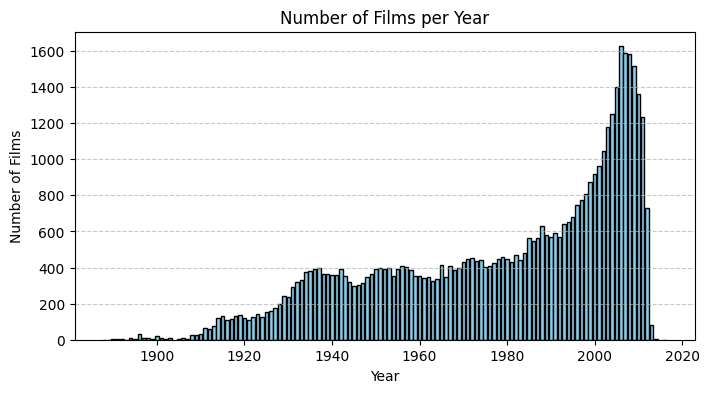

In [12]:
grouped_year = cmu_movies.groupby(cmu_movies.release_date.dt.year).agg(number_films=('movie_name','count')) \
                         .reset_index()

plt.figure(figsize=(8, 4))
plt.bar(grouped_year['release_date'], grouped_year['number_films'], color='skyblue', edgecolor='black')
plt.title('Number of Films per Year')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It seems the number of movies per year increases with years. Let's see a bit more in details how many years have less than 100, 500, 1000 movies.

In [13]:
# Print the years with less than 100, 500, and 1000 films
years_less_than_100 = grouped_year[grouped_year['number_films'] < 100]['release_date']
years_less_than_500 = grouped_year[grouped_year['number_films'] < 500]['release_date']
years_less_than_1000 = grouped_year[grouped_year['number_films'] < 1000]['release_date']

print(f'Number of years with less than 100 films: {len(years_less_than_100)}')
print(f'Number of years with less than 500 films: {len(years_less_than_500)}')
print(f'Number of years with less than 1000 films: {len(years_less_than_1000)}')

# Print the year with the max number of movies
max_films_year = grouped_year.loc[grouped_year['number_films'].idxmax(), 'release_date']
max_films_count = grouped_year['number_films'].max()
print(f'The year with the max number of films is: {max_films_year:.0f} with {max_films_count} films')

Number of years with less than 100 films: 28
Number of years with less than 500 films: 99
Number of years with less than 1000 films: 117
The year with the max number of films is: 2006 with 1625 films


We see that there are not that much years with less than 100 movies. We will drop them from our dataset, in order to have more significant results when we will do year based analysis.

In [14]:
# In the original CMU dataset remove the rows with release year with less than 100 films
years_to_remove = grouped_year[grouped_year['number_films'] < 100]['release_date'].tolist()
cmu_movies = cmu_movies[~cmu_movies.release_date.dt.year.isin(years_to_remove)].copy()

We have also the problem that so far the values in the columns 'language', 'country' and 'genre' are still in a object format and not easily usable. We will need to convert them to a more usable format. For an easy access to those values later we will interpret them as dictionaries that we'll convert to a list format since we do not need the keys (that come from freebase).

In [15]:
# Transform the object dtype into list of values:
# We use ast.literal_eval to interpret the string as a dictionnaries, we take only their values and 
# we convert it to a list
cmu_movies['language'] = cmu_movies['language'].apply(lambda x: list(ast.literal_eval(x).values())) 
cmu_movies['country'] = cmu_movies['country'].apply(lambda x: list(ast.literal_eval(x).values()))
cmu_movies['genre'] = cmu_movies['genre'].apply(lambda x: list(ast.literal_eval(x).values()))

# Check the max number of values in each list(i.e. the max number of languages, countries and genres for a movie)
print(f'The max number of values in a single list for language is {cmu_movies["language"].apply(len).max()}')
print(f'The max number of values in a single list for country is {cmu_movies["country"].apply(len).max()}')
print(f'The max number of values in a single list for genre is {cmu_movies["genre"].apply(len).max()}')

The max number of values in a single list for language is 11
The max number of values in a single list for country is 14
The max number of values in a single list for genre is 17


In [16]:
# Cleaned version of the CMU dataset
cmu_movies

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,tconst,averageRating,numVotes
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,4.9,57085
1,28463795,/m/0crgdbh,brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",tt0094806,5.6,42
2,9363483,/m/0285_cd,white of the eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320,6.1,2917
3,261236,/m/01mrr1,a woman in flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],tt0083949,5.9,625
5,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",tt0029852,6.8,2283
...,...,...,...,...,...,...,...,...,...,...,...,...
49983,15394941,/m/03m6zh4,gopi kishan,1994-12-02,NaN,NaN,[Hindi Language],[India],"[Drama, Action, Crime, Comedy]",tt0109922,5.8,973
49984,23851782,/m/06_vb43,the ghost train,1941-05-03,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",tt0033660,6.2,1588
49985,35228177,/m/0j7hxnt,mermaids: the body found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],tt1816585,4.6,1713
49986,34980460,/m/0g4pl34,knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259,6.8,3204


In [17]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49470 entries, 0 to 49987
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   wikiID          49470 non-null  int64         
 1   freebase_movID  49470 non-null  object        
 2   movie_name      49470 non-null  object        
 3   release_date    49470 non-null  datetime64[ns]
 4   boxoffice       7460 non-null   float64       
 5   runtime         41684 non-null  float64       
 6   language        49470 non-null  object        
 7   country         49470 non-null  object        
 8   genre           49470 non-null  object        
 9   tconst          49470 non-null  object        
 10  averageRating   49470 non-null  float64       
 11  numVotes        49470 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 4.9+ MB


We see here that we have enough data for our analysis.

#### 1.2 Characters dataset

Now that we have a usable and clean dataset for the movies we will interest ourselves in the character dataset. To do that let first have a look at the dataset.

In [18]:
cmu_character_cols = ['wikiID',
                      'freebase_movID',
                      'release_date',
                      'character_name',
                      'actor_birth',
                      'actor_gender',
                      'actor_height',
                      'actor_ethnicity',
                      'actor_name',
                      'actor_age_at_release',
                      'freebase_char_actor_map',
                      'freebase_charID',
                      'freebase_actorID']

cmu_character = pd.read_table(cmu_path+'character.metadata.tsv', names=cmu_character_cols)

ethnicity_map = pd.read_table(data_path+'ethnicities_data.tsv', sep='\t', index_col=0).to_dict()['Ethnicities']
cmu_character['actor_ethnicity'] = cmu_character['actor_ethnicity'].map(ethnicity_map)
ethnicity_map = pd.read_table(data_path+'ethnicity_group_data.tsv', sep='\t', index_col=0).to_dict()['Ethnic Group']
cmu_character['actor_ethnicity'] = cmu_character['actor_ethnicity'].map(ethnicity_map)

cmu_character.sample(5)

,wikiID,freebase_movID,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID
237871,5353344,/m/0dg_ns,2005-07-08,Jagannath,1963,M,NaN,"Asian, Middle East and Tribes",Piyush Mishra,42.0,/m/02b8qjy,/m/0h7275r,/m/026p3wd
331169,5872126,/m/0fb2x_,1990-06-15,Cameraman,NaN,M,NaN,NaN,Jim Bracken,NaN,/m/0lrpkyn,/m/0lrwrq0,/m/0lrpkyr
233772,9526988,/m/02phx2q,1992,NaN,1960-01-21,M,NaN,NaN,Dmitry Kharatyan,31.0,/m/0jx6tsf,NaN,/m/08wm30
56367,24168980,/m/07k50mv,2009-06-26,NaN,NaN,NaN,NaN,NaN,Jiji Bû,NaN,/m/0gc6_p1,NaN,/m/0gc3xgr
159768,8711818,/m/027fwvb,1976-11-10,NaN,1934-01-07,F,NaN,NaN,Jamila Massey,42.0,/m/0k1ylnd,NaN,/m/02q9_x2


In [19]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   wikiID                   450669 non-null  int64  
 1   freebase_movID           450669 non-null  object 
 2   release_date             440674 non-null  object 
 3   character_name           192794 non-null  object 
 4   actor_birth              344524 non-null  object 
 5   actor_gender             405060 non-null  object 
 6   actor_height             154824 non-null  float64
 7   actor_ethnicity          102903 non-null  object 
 8   actor_name               449441 non-null  object 
 9   actor_age_at_release     292556 non-null  float64
 10  freebase_char_actor_map  450669 non-null  object 
 11  freebase_charID          192804 non-null  object 
 12  freebase_actorID         449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


We will first drop any null value we have on the wikiID column or in the freebase_actorID column since we don't want character without actor or movie, we also drop the dupplicates if we have more than one character for the same actor in the same movie.

In [20]:
cmu_character.dropna(subset=['wikiID','freebase_actorID'], inplace=True)
cmu_character.drop_duplicates(subset=['wikiID','freebase_actorID'], inplace=True)

We will now create a dataset containing the information about the actors and the movies they played in.

In [21]:
actor_movie = cmu_character.drop(columns='release_date', axis=1) \
                           .merge(cmu_movies[['wikiID','averageRating','numVotes','release_date','tconst']],
                                  on='wikiID',how='inner')
actor_movie.head(5)

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date,tconst
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,4.9,57085,2001-08-24,tt0228333
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,4.9,57085,2001-08-24,tt0228333
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,"Black, Caribbean or African",Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,4.9,57085,2001-08-24,tt0228333
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,4.9,57085,2001-08-24,tt0228333
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,4.9,57085,2001-08-24,tt0228333


In [22]:
# We also add the principal actors for each movie
imdb_principals = pd.read_csv(data_path+'name_principals.csv')
imdb_principals.primaryName  = imdb_principals.primaryName.str.lower()
imdb_principals['is_principal'] = 1

actor_movie = actor_movie.merge(imdb_principals,
                                how="left",
                                left_on=['tconst',actor_movie.actor_name.str.lower()],
                                right_on=['tconst','primaryName']).drop(columns=['tconst','primaryName'])
actor_movie['is_principal'].fillna(0, inplace = True)

cmu_character = actor_movie.drop(columns=['averageRating','numVotes']).copy()
cmu_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,is_principal
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001-08-24,0.0
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001-08-24,0.0
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,"Black, Caribbean or African",Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001-08-24,1.0
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001-08-24,1.0
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001-08-24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331136,9971909,/m/02pygw1,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,1972-09-22,1.0
331137,9971909,/m/02pygw1,NaN,1918-10-02,M,NaN,NaN,Herb Voland,53.0,/m/0ggdv2_,NaN,/m/02qylb9,1972-09-22,1.0
331138,28308153,/m/0cp05t9,NaN,1941-11-18,M,1.730,White,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,1957-01-01,1.0
331139,28308153,/m/0cp05t9,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,1957-01-01,0.0


Now that we a cleaned dataset of character with the corresponding fame score of each actor, we would like that have more information on the character the actor is playing in this movie. For that we will use the persona dataset to be able later to understand the relation between the character and the actor. 

In [23]:
acl_persona_cols = ['entity_id',
                    'wikiID',
                    'movie_name',
                    'entity_name',
                    'full_entity_name',
                    'entity_num_event',
                    'persona',
                    'final_posterior']

acl_persona = pd.read_table(acl_persona_path+'25.100.lda.log.txt', header=None, names=acl_persona_cols)
acl_persona.sample(5)

,entity_id,wikiID,movie_name,entity_name,full_entity_name,entity_num_event,persona,final_posterior
95661,e20,28833073,She'll Follow You Anywhere,they,they,4,23,0.00000 0.01000 0.06000 0.00000 0.00000 0.0000...
65107,/m/09vkk90,226682,Casualties of War,PFC Antonio Diaz,Diaz,4,35,0.00000 0.00000 0.00000 0.00000 0.00000 0.0000...
56735,e5,20891648,A Life of Her Own,he,Steve,11,49,0.00000 0.00000 0.01000 0.05000 0.00000 0.0000...
47888,e14,19094868,Dead Space: Downfall,he,he,5,35,0.00000 0.04000 0.00000 0.00000 0.00000 0.0100...
113973,e9,33375298,Cocktail,Gautam,Gautam and Meera,3,3,0.00000 0.00000 0.15000 0.44000 0.00000 0.0000...


We want now to populate our cmu_character dataframe with those informations about the personas.

In [24]:
cmu_character = cmu_character.merge(acl_persona[['entity_id','persona']], 
                                    left_on='freebase_char_actor_map', 
                                    right_on='entity_id', how='left').drop(columns='entity_id')

# Print the final dataset
cmu_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,is_principal,persona
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001-08-24,0.0,NaN
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001-08-24,0.0,35.0
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,"Black, Caribbean or African",Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001-08-24,1.0,NaN
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001-08-24,1.0,NaN
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001-08-24,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331150,9971909,/m/02pygw1,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,1972-09-22,1.0,NaN
331151,9971909,/m/02pygw1,NaN,1918-10-02,M,NaN,NaN,Herb Voland,53.0,/m/0ggdv2_,NaN,/m/02qylb9,1972-09-22,1.0,NaN
331152,28308153,/m/0cp05t9,NaN,1941-11-18,M,1.730,White,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,1957-01-01,1.0,NaN
331153,28308153,/m/0cp05t9,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,1957-01-01,0.0,NaN


In [25]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331155 entries, 0 to 331154
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   wikiID                   331155 non-null  int64         
 1   freebase_movID           331155 non-null  object        
 2   character_name           151480 non-null  object        
 3   actor_birth              255827 non-null  object        
 4   actor_gender             299224 non-null  object        
 5   actor_height             122685 non-null  float64       
 6   actor_ethnicity          78220 non-null   object        
 7   actor_name               330861 non-null  object        
 8   actor_age_at_release     225084 non-null  float64       
 9   freebase_char_actor_map  331155 non-null  object        
 10  freebase_charID          151485 non-null  object        
 11  freebase_actorID         331155 non-null  object        
 12  release_date    

# Fame score computation

First consider the data we have for each movies. We have the number of votes, the rate, the principal actors and also the date of release. One can assume that an actor fame will increase after a good movie and then decrease exponentially while he is not appearing in any other movies. This is the kind of shape we expect for a fame score.

We can first evaluate the instantaneous fame of an actor in a specific movie. It should be related to all the parameters we mentionned. But one can note that the overall number of votes increase with the time so we need to rescale it.

In [26]:
actor_movie.sample(5)

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date,is_principal
132999,22539062,/m/05zhkq4,NaN,1912-06-08,M,1.9558,NaN,Henry Brandon,41.0,/m/0gcg2_s,NaN,/m/06l7l0,5.8,1458,1953-06-15,0.0
131047,12610088,/m/02wxsz0,NaN,1931,M,NaN,"Asian, Middle East and Tribes",Yunus Parvez,64.0,/m/09j082k,NaN,/m/028bs1p,5.7,227,1995-09-15,0.0
142890,473286,/m/02drxn,Pip's Comic,1967,M,NaN,NaN,Anthony Arkin,36.0,/m/0g_tkp2,/m/0g_tkp5,/m/02qfy3w,6.3,32358,2003-08-27,0.0
253722,5266283,/m/0dbn8t,Sunil,NaN,NaN,NaN,NaN,Sanjay Chandani,NaN,/m/0cmkz8d,/m/0cmkz8h,/m/0cmkz8q,7.2,10146,2000-01-01,0.0
294059,1232216,/m/04klm3,Em,1925-10-16,F,1.7300,White,Angela Lansbury,20.0,/m/02tbbkn,/m/0gyj_g2,/m/0161h5,7.0,4741,1946-01-18,0.0


<function matplotlib.pyplot.show(close=None, block=None)>

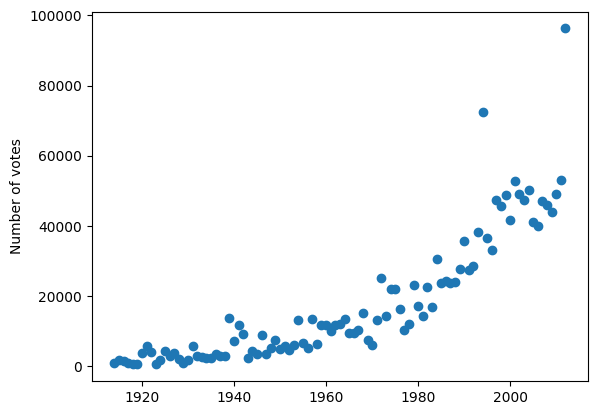

In [27]:
votes_per_year = actor_movie[['release_date','numVotes']].groupby(actor_movie['release_date'].dt.year)[['numVotes']].agg("mean")
plt.scatter(votes_per_year.index,votes_per_year.numVotes)
plt.ylabel('Number of votes')
plt.show

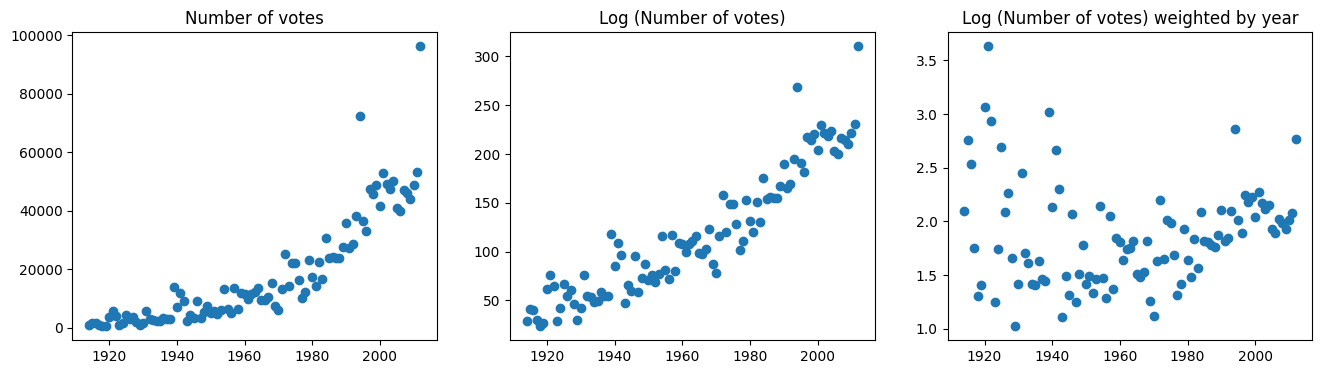

In [28]:
fig, axis = plt.subplots(1,3,figsize=(16,4))

axis[0].scatter(votes_per_year.index,votes_per_year.numVotes)
axis[0].set_title('Number of votes')

axis[1].scatter(votes_per_year.index,np.sqrt(votes_per_year.numVotes))
axis[1].set_title('Log (Number of votes)')

axis[2].scatter(votes_per_year.index,np.sqrt(votes_per_year.numVotes)/(votes_per_year.index-1900))
axis[2].set_title('Log (Number of votes) weighted by year')


plt.show()

In [29]:
def instant_fame_score(row,data):
    year = row['release_date'].year
    rate = row['averageRating']
    votes = row['numVotes']
    is_principal = row['is_principal']

    instant_fameScore = rate * np.sqrt(votes) / (year-1900) * (1 + 0.2*is_principal)

    return instant_fameScore

actor_movie.sort_values(by=['freebase_actorID','release_date'], inplace=True)
actor_movie['instant_fameScore'] = actor_movie.apply(lambda x: instant_fame_score(x,actor_movie), axis=1)

In [30]:
def get_fame_score(df, mode='before_after_films'):
    df = df.sort_values('release_date')

    dates = df['release_date'].to_numpy()
    if mode=='filmography':
        # every day between first and last films
        time_range = pd.date_range(dates[0], dates[-1], freq='D').to_list()
    elif mode=='before_after_films':
        # day before and release date of films
        time_range = np.hstack(list(map(lambda d: [d-pd.Timedelta(days=1),d-pd.Timedelta(days=0)], dates)))
    
    # make time_range non decreasing against cases with two films on the same day
    time_range = np.maximum.accumulate(time_range)
    #create a time_range for each films
    time_ranges = np.expand_dims(time_range, axis=0).repeat(axis=0,repeats=len(dates))
    #convert each time range to the number of days from film release date
    day_deltas = np.array(list(map(lambda x : list(map(lambda y,z: (y - dates[z]).days, x[1], [x[0]]*len(time_range))), enumerate(time_ranges))))
    # get exponential for each film
    exps = np.array(list(map(lambda x: np.exp(-x/4/365/5), day_deltas))) # CAN CHANGE DECAY HERE

    # mask exponential part before film release, treated in two cases to deal with films released on the same day issue
    if mode=='filmography':
        mask = exps>1
        exps[exps>1] = 0
    elif mode=='before_after_films':
        idx = np.indices(exps.shape)
        mask = idx[1]<2*idx[0]+1
        exps[mask] = 0
    
    exps = np.diag(df['instant_fameScore'])@exps # CAN CHANGE SCALING HERE
    mean_exps = np.array(list(map(lambda x: x[x!=0].mean() if len(x[x!=0])>0 else 0,exps.T)))
    return time_range, mean_exps

def fame_score(df, mode='before_after_films'):
    if mode=='filmography':
        return get_fame_score(df, mode='filmography')
    elif mode=='before_after_films':
        _, fame_scores = get_fame_score(df)
        df['fameScore_before']=fame_scores[2*np.arange(len(fame_scores)//2)]
        df['fameScore']=fame_scores[2*np.arange(len(fame_scores)//2)+1]
        df['fameScore_diff']=df['fameScore']-df['fameScore_before']
        return df

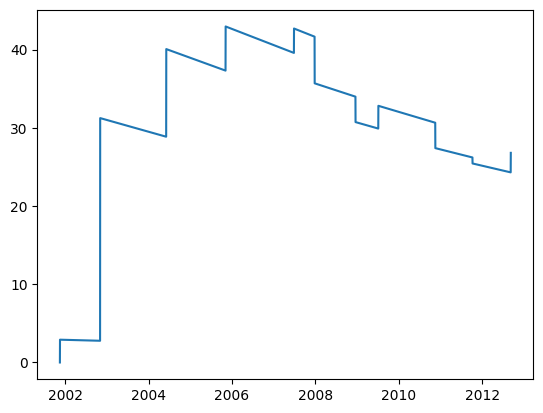

In [31]:
# df=actor_movie.query("freebase_actorID=='/m/010p3'")
df = actor_movie[actor_movie['actor_name']=='Emma Watson']
time_range, sumexps = get_fame_score(df, 'before_after_films')

plt.plot(time_range, sumexps)
plt.show()

In [32]:
actor_movie = actor_movie.groupby('freebase_actorID').apply(fame_score).reset_index(drop=True)
actor_movie.sample(5)

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date,is_principal,instant_fameScore,fameScore_before,fameScore,fameScore_diff
288226,31417051,/m/0gkyllf,NaN,1972-10-26,M,NaN,NaN,Riaz,24.0,/m/0gl26s8,NaN,/m/0gh6zgt,6.1,44,1997-01-01,1.0,0.500571,0.273326,0.386930,0.113604
210281,2299232,/m/071zqj,NaN,NaN,NaN,NaN,NaN,Marit Pia Jacobsen,NaN,/m/0bgk5l_,NaN,/m/0bgk5ly,7.5,15660,2001-01-01,0.0,9.292568,0.000000,9.292568,9.292568
251916,5398963,/m/0dk285,NaN,NaN,M,NaN,NaN,J. Michael Hunter,NaN,/m/0gby4fs,NaN,/m/0g40ml_,6.0,13982,1989-01-01,0.0,7.971607,36.495719,22.231164,-14.264555
91890,6526603,/m/0g8z37,NaN,1969-06-11,M,NaN,NaN,Matt McGrath,22.0,/m/09hzwtm,NaN,/m/03gxzf3,5.3,417,1992-05-17,1.0,1.411683,4.993700,3.202350,-1.791350
32538,3091175,/m/08qtld,NaN,1950-02-12,M,1.78,White,Michael Ironside,49.0,/m/0jz9bt,NaN,/m/02184q,5.4,9170,2000-01-01,1.0,6.205256,5.932964,5.940184,0.007220


In [33]:
cmu_character = cmu_character.merge(actor_movie[['freebase_movID','freebase_actorID','fameScore_before','fameScore','fameScore_diff']],on=['freebase_movID','freebase_actorID'],how='left')

In [112]:
def plot_filmography(actor_name):
    '''
    This function plots the fame score of an actor along the years and the movies he played in
    '''

    filmography = cmu_character.query(f"actor_name=='{actor_name}'").sort_values('release_date')
    filmography = filmography.merge(cmu_movies[['wikiID','movie_name']], on='wikiID')

    # Create a scatter plot with go.Scatter
    fig = go.Figure()

    # Scatter plot for individual data points
    for idx, row in filmography.iterrows():
        fig.add_trace(go.Scatter(
            x=[row['release_date']],
            y=[row['fameScore']],
            mode='markers',
            marker=dict(symbol='circle', size=8, color=SING_COLOR, line=dict(color=SING_COLOR, width=1)),
            text=idx + 1, textposition='top right',
            name=f"{idx + 1} : {row['movie_name']}"
        ))

    # Line plot connecting the dots
    fig.add_trace(go.Scatter(
        x=filmography['release_date'],
        y=filmography['fameScore'],
        mode='lines',
        line=dict(color=SING_COLOR, width=1),
        showlegend=False  # Exclude this trace from the legend
    ))
    # Adjust the position of the annotations
    #fig.update_traces(textposition='top right', textfont_size=8)
    
    # Customize layout
    fig.update_layout(
        title=f'Fame score for {actor_name} along years',
        xaxis=dict(title='Year'),
        yaxis=dict(title='Fame Score after release'),
        legend=dict(title='Movie Name'),
        width=1000,
        height=700,
    )

    for idx, row in filmography.iterrows():
        fig.add_annotation(
            x=row['release_date'],
            y=row['fameScore'],
            text=str(idx + 1),
            showarrow=False,
            font=dict(size=8),
            xanchor='right',
            yanchor='bottom'
        )
        
    fig.show()

In [134]:
plot_filmography('Christian Bale')

In [36]:
cmu_character.to_csv('data/cmu_character.csv',index=False)

## 2. Data analysis

In the first part we will try to confirm if the fame score is a good indicator of the success of an actor.

Then we will start looking at the impact of different variables on the fame score in order to have a first glimpse at the way to succeed for an actor. This will allow us to assess the relevance of our problematic.

### 2.1 Relation between Box Office, Ratings, and Votes

For the moment we assumed that we could use the ratings as a proxy for the success of a movie. We will now try to see if this assumption is correct (if the ratings are correlated with the box office).

First we clean the cmu_movies to remove rows where either rating or boxoffice is missing.

In [37]:
#Remove rows where both boxoffice and rating are missing
movies_df = cmu_movies.dropna(subset=['boxoffice','averageRating']).copy()

Before doing any analysis we will also adjust the boxoffice to take into account the inflation (i.e., values will be in 2020 dollars)

In [38]:
movies_df["adj_boxoffice"] = movies_df.apply(lambda x: cpi.inflate(x["boxoffice"], x.release_date.year, to=2020), axis=1)

Let's now plot the boxoffice and the ratings taking into account the number of votes and the year of the movie, to see if there is any noticeable relation between those variables.

In [94]:
# Divide data into 4 different time periods
periods = [(1901, 1940), (1941, 1980), (1981, 2000), (2001, 2020)]

# Create a new column 'period' in movies_df based on release year
movies_df['period'] = pd.cut(movies_df['release_date'].dt.year, bins=[period[0] for period in periods] + [np.inf],
                             labels=[f'{start}-{end}' for (start, end) in periods])


# Define the chronological order of the periods
category_order = [f'{start}-{end}' for (start, end) in periods]

# Scatter plot with larger dots based on 'numVotes' and color based on 'period'
fig = px.scatter(movies_df, x='averageRating', y='adj_boxoffice', size='numVotes',
                 color='period', color_discrete_sequence=MULT_COLOR,
                 opacity=0.5, labels={'numVotes': 'Number of Votes (Ks of votes)'},
                 category_orders={'period': category_order},
                 size_max=60,  # Set the maximum size of the dots
                 title='Adjusted Boxoffices with respect to rating (size dots based on number of votes)',
                 width=1000, height=1000,
                 log_y=True,  # Include log scale on the y-axis
                 template=TEMPLATE)  # Set the template to 'plotly_white' or choose another template
# Add a border around the dots
fig.update_traces(marker=dict(line=dict(color='black', width=1)),
                  selector=dict(mode='markers'))

fig.update_layout(
    legend=go.layout.Legend(
        title=dict(text='Period of time')  # Set the title of the legend
    ),
    xaxis_title='Average Rating on IMDb',  # Set the label for the x-axis
    yaxis_title='Adjusted Boxoffice [$ in 2020]'   # Set the label for the y-axis
)

fig.show()

From this plot we can derive several informations:

- Films with high number of votes tend to have high ratings and high boxoffice. This is not surprising since the more people watch a movie, the more likely it is to be good and to have a high boxoffice.
- The boxoffice seems to be higher with years.
- Films with low rating tend to have lower number of votes. Is it because people don't watch them based on their low ratings.

We will look at the correlation matrix to have a better understanding at the potential correlation we could find between the variables.

In [95]:
# Calculate the correlation matrix
correlation_matrix = movies_df[['boxoffice', 'runtime', 'averageRating', 'numVotes', 'release_date']]\
                              .corr(method='pearson')

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,  # Use the values from the DataFrame
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='Blues',  # Use the 'Blues' colormap
    colorbar=dict(title='Correlation'),
    text=correlation_matrix.values.round(2),  # Annotate with rounded correlation values
    hoverongaps=False,
))

# Set layout properties
fig.update_layout(
    title='Correlation Heatmap',
    xaxis=dict(title='X-axis Label'),  # Replace 'X-axis Label' with your actual label
    yaxis=dict(title='Y-axis Label'),  # Replace 'Y-axis Label' with your actual label
    width=800,
    height=600,
)

fig.show()

This tends to show that the rating and the boxoffice are not correlated. However We have a big correlation between the number of votes, the boxoffice and the rating. 

We confirmed the fact that the more a film is voted the more it tends to have a high rating and a high boxoffice. As we use in the fame score the rating * log(number of votes) we can assume as a first approximation that we capture well the success of a movie an actor plays in and thus the fame of the actor gained thanks to this movie. 

The fact that we explicitly use the rating combined with the number of votes has the effect to give more fame to an actor that plays in "good" movies, movies with high ratings (it is more important for an actor to play in a good movie than in a bad one even if the bad one can sometime bring more money (bigger boxoffice)).

### 2.2 Fame score analysis

#### 2.2.1 Fame score for gender and ethnicity

In [119]:
columns_of_interest = ['release_date', 'actor_gender', 'fameScore']
cmu_character_subset = cmu_character[columns_of_interest].copy()  # Ensure you make a copy

# Convert 'release_date' to datetime
cmu_character_subset['release_date'] = pd.to_datetime(cmu_character_subset['release_date'], errors='coerce', format='mixed')

# Transform 'release_date' into 'release_year'
cmu_character_subset['release_year'] = cmu_character_subset['release_date'].dt.year

# Group by year and calculate the average fame score for each year for both male and female actors
yearly_avg_fame_score = cmu_character_subset.groupby(['release_year', 'actor_gender'])['fameScore'].mean().reset_index()

# Pivot the table to have gender as columns
pivot_table = yearly_avg_fame_score.pivot(index='release_year', columns='actor_gender', values='fameScore').reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(pivot_table, x='release_year', y=['M', 'F'],
             labels={'value': 'Average Fame Score', 'release_year': 'Year'},
             title='Average Fame Score Over the Years by Gender',
             color_discrete_map={'M': COMP_COLOR1[0], 'F': COMP_COLOR1[1]},
             height=400, width=1000, template=TEMPLATE)

# Show the plot
fig.show()

In [121]:
columns_of_interest = ['release_date', 'actor_gender', 'fameScore']
cmu_character_subset = cmu_character[columns_of_interest].copy()  # Ensure you make a copy

# Convert 'release_date' to datetime
cmu_character_subset['release_date'] = pd.to_datetime(cmu_character_subset['release_date'], errors='coerce', format='mixed')

# Transform 'release_date' into 'release_year'
cmu_character_subset['release_year'] = cmu_character_subset['release_date'].dt.year

# Group by year and calculate the average fame score for each year for both male and female actors
yearly_avg_fame_score = cmu_character_subset.groupby(['release_year', 'actor_gender'])['fameScore'].mean().reset_index()

# Pivot the table to have gender as columns
pivot_table = yearly_avg_fame_score.pivot(index='release_year', columns='actor_gender', values='fameScore').reset_index()

# Calculate the ratio of male to female average fame scores
pivot_table['M/F_ratio'] = pivot_table['M'] / pivot_table['F']

# Create a bar plot 
fig = px.bar(pivot_table, x='release_year', y='M/F_ratio',
             labels={'M/F_ratio': 'Male/Female Ratio of Average Fame Score', 'release_year': 'Year'},
             title='Male/Female Ratio of Average Fame Score Over the Years',
             color_discrete_sequence=[SING_COLOR], 
             height=400, width=1000, template=TEMPLATE)

# Show the plot
fig.show()

In [123]:
columns_of_interest = ['release_date', 'actor_ethnicity', 'fameScore']
cmu_character_subset = cmu_character[columns_of_interest].copy()  # Ensure you make a copy

# Convert 'release_date' to datetime
cmu_character_subset['release_date'] = pd.to_datetime(cmu_character_subset['release_date'], errors='coerce', format='mixed')

# Transform 'release_date' into 'release_year'
cmu_character_subset['release_year'] = cmu_character_subset['release_date'].dt.year

# Group by year and calculate the average fame score for each ethnicity 
yearly_avg_fame_score = cmu_character_subset.groupby(['release_year', 'actor_ethnicity'])['fameScore'].mean().reset_index()

# Pivot the table to have gender as columns
pivot_table = yearly_avg_fame_score.pivot(index='release_year', columns='actor_ethnicity', values='fameScore').reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(pivot_table, x='release_year', y=pivot_table.columns,
             labels={'value': 'Average Fame Score', 'release_year': 'Year'},
             title='Average Fame Score Over the Years by Ethnicity',
             color_discrete_sequence=COMP_COLOR2,
             height=400, width=1000, template=TEMPLATE)

# Show the plot
fig.show()

#### 2.2.2 Fame score over the years

In [124]:
columns_of_interest = ['wikiID', 'release_date', 'actor_name', 'fameScore']
cmu_character_subset = cmu_character[columns_of_interest].copy()
# Convert 'release_date' to datetime
cmu_character_subset['release_date'] = pd.to_datetime(cmu_character_subset['release_date'], errors='coerce', format='mixed')
# Transform 'release_date' into 'release_year'
cmu_character_subset['release_year'] = cmu_character_subset['release_date'].dt.year

# Group by 'release_year' and 'actor_name'
grouped_data = cmu_character_subset.groupby(['release_year', 'actor_name'])

# For each group, select the row with the highest 'fameScore'
cmu_character_subset = grouped_data.apply(lambda x: x.loc[x['fameScore'].idxmax()]).reset_index(drop=True)

# Sort the values by year
cmu_character_subset = cmu_character_subset.sort_values(by='release_year').reset_index(drop=True)

In [125]:
cmu_character_subset.head()

,wikiID,release_date,actor_name,fameScore,release_year
0,238484,1914-11-14,A. Edward Sutherland,26.824863,1914
1,8906198,1914-05-07,Luis García Lawson,2.535173,1914
2,238484,1914-11-14,Mabel Normand,11.876737,1914
3,12856014,1914-11-28,Mabel Paige,2.472378,1914
4,11450820,1914-06-01,Mack Sennett,13.808326,1914


In [128]:
my_raceplot = barplot(cmu_character_subset,
                      item_column='actor_name',
                      value_column='fameScore',
                      time_column='release_year',
                      top_entries=10)

fig = my_raceplot.plot(title = 'Top 10 famous actors from 1914 to 2013',
                 item_label = 'Top 10 famous actors',
                 value_label = 'Fame Score',
                 frame_duration = 800)

fig.update_layout(colorway=MULT_COLOR, template=TEMPLATE)

#### 2.2.3 Fame Score with respect to the number of movies played

Let's find how many movies must be played by an actor before he reached his maximum fame score.

In [ ]:
cmu_character_sorted = cmu_character.sort_values(by=['actor_name', 'release_date'])

# Initialize a new column to store the maximum fame score for each actor
cmu_character_sorted['max_fame_score'] = cmu_character_sorted.groupby('actor_name')['fameScore'].transform('max')

# Initialize a new column to store the cumulative count of films before reaching max fame score
cmu_character_sorted['films_before_max'] = cmu_character_sorted.groupby('actor_name').cumcount()+1

# Filter rows where fame score is equal to max fame score (easier to plot like this)
df_filtered = cmu_character_sorted[cmu_character_sorted['fameScore'] == cmu_character_sorted['max_fame_score']].reset_index(drop=True)


fig1 = px.histogram(df_filtered, x="films_before_max", color="actor_gender", template=TEMPLATE, 
                        color_discrete_map={'M': COMP_COLOR1[0], 'F': COMP_COLOR1[1]},
                        opacity=1, 
                        histnorm='percent',
                        log_y=True, hover_data=df_filtered.columns, 
                        title = 'How Many Films Before an actor reaches its maximum Famescore ?', 
                        marginal="violin",
                        height = 1000, width = 1000
)

fig2 = px.histogram(df_filtered, x="films_before_max", color="actor_ethnicity", template=TEMPLATE, 
                        color_discrete_sequence=COMP_COLOR2,
                        opacity=1, 
                        histnorm='percent',
                        log_y=True, hover_data=df_filtered.columns, 
                        title = 'How Many Films Before an actor reaches its maximum Famescore ?', 
                        marginal="violin",
                        height = 1000, width = 1000
)
# Add a range slider to control the visual interval and make it more readable
fig1.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="linear"))
fig2.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="linear"))

# Overlay both histograms (if you want to have a better visu you can remove the 4 lines below and instead you will have values of each category which stack upon each other)
fig1.update_layout(barmode='overlay')
fig1.update_traces(opacity=0.5)

fig2.update_layout(barmode='overlay')
fig2.update_traces(opacity=0.5)


# Show the plot
fig1.show()
fig2.show()

The problem with this analysis is that we don't see difference for high and low fame score. It means we don't know if actors reaching quickly their higher fame score have a high or low one. Indeed it is something to reach a low fame score quickly but it is another thing to reach a high fame score quickly.

In [ ]:
max_fameScore = df_filtered['fameScore'].max()

# Define the dataset filters to get only small to high fame scores values
filters = [
    df_filtered[df_filtered['fameScore'] <= 0.1 * max_fameScore],
    df_filtered[(0.1 * max_fameScore < df_filtered['fameScore'])& (df_filtered['fameScore'] <= 0.25 * max_fameScore)],
    df_filtered[(0.25 * max_fameScore < df_filtered['fameScore']) & (df_filtered['fameScore'] <= 0.5 * max_fameScore)],
    df_filtered[(0.5 * max_fameScore < df_filtered['fameScore']) & (df_filtered['fameScore'] <= 0.75 * max_fameScore)],
    df_filtered[(0.75 * max_fameScore < df_filtered['fameScore']) & (df_filtered['fameScore'] <= max_fameScore)]
]

# Create and display plots for each dataset
for i, df_filtered_i in enumerate(filters):
    # Plot in the style of fig1
    fig1 = px.histogram(
        df_filtered_i,
        x="films_before_max",
        color="actor_gender",
        template=TEMPLATE,
        color_discrete_map={'M': COMP_COLOR1[0], 'F': COMP_COLOR1[1]},
        opacity=1,
        histnorm='percent',
        log_y=True,
        hover_data=df_filtered_i.columns,
        title=f'How Many Films Before reaching its maximum Fame Score? (Dataset {i + 1})',
        marginal="violin",
        height=500,
        width=500
    )

    # Add a range slider to control the visual interval and make it more readable
    fig1.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="linear"))

    # Overlay histograms
    fig1.update_layout(barmode='overlay')
    fig1.update_traces(opacity=0.5)

    # Show the plot
    fig1.show()

    # Plot in the style of fig2
    fig2 = px.histogram(
        df_filtered_i,
        x="films_before_max",
        color="actor_ethnicity",
        template=TEMPLATE,
        color_discrete_sequence=COMP_COLOR2,
        opacity=1,
        histnorm='percent',
        log_y=True,
        hover_data=df_filtered_i.columns,
        title=f'How Many Films Before reaching its maximum Fame Score? (Dataset {i + 1})',
        marginal="violin",
        height=500,
        width=500
    )

    # Add a range slider to control the visual interval and make it more readable
    fig2.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="linear"))

    # Overlay histograms
    fig2.update_layout(barmode='overlay')
    fig2.update_traces(opacity=0.5)

    # Show the plot
    fig2.show()


#### 2.2.4 Fame Score evolution over the career of an actor (could be put after the filmography since it is actually an avg filmography)

After these different visualizations, let's try to determine some pattern in the fame score evolution over the years in average for all the actors.

We will use the cmu_character dataset and select actors who played 10 movies or more to have a more visual result.

In [139]:
# Convert 'release_date' to datetime
cmu_character['release_date'] = pd.to_datetime(cmu_character['release_date'], errors='coerce', format='mixed')
# Transform 'release_date' into 'release_year'
cmu_character['release_year'] = cmu_character['release_date'].dt.year
# Create a new column 'number_films' in cmu_character (use freebase_actorID instead of actor_name since there are actors with same name)
cmu_character['number_films'] = cmu_character.groupby('freebase_actorID')['freebase_actorID'].transform('count')
# Remove rows where actor_age_at_release is negative
cmu_character = cmu_character[cmu_character['actor_age_at_release'] >= 0].copy()
# Sort the values by year
cmu_character = cmu_character.sort_values(by='release_year').reset_index(drop=True)

# print the dataset for actor_name = 'Emma Watson'
cmu_character[cmu_character['actor_name'] == 'Emma Watson']

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,is_principal,persona,fameScore_before,fameScore,fameScore_diff,release_year,number_films
145667,667361,/m/03176f,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,11.0,/m/0jz6k3,/m/0c8kc,/m/0134w7,2001-11-16,0.0,1.0,0.000000,2.912692,2.912692,2001,11
149130,667368,/m/031778,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,12.0,/m/0jz6bb,/m/0c8kc,/m/0134w7,2002-11-03,0.0,34.0,2.775957,31.239484,28.463527,2002,11
161082,667371,/m/03177r,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,14.0,/m/0jz6n0,/m/0c8kc,/m/0134w7,2004-06-04,0.0,34.0,28.861390,40.060699,11.199309,2004,11
171543,667372,/m/031786,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,15.0,/m/0jz6f8,/m/0c8kc,/m/0134w7,2005-11-06,0.0,1.0,37.311437,42.952186,5.640749,2005,11
183990,12634263,/m/02wyzmv,Pauline Fossil,1990-04-15,F,1.68,White,Emma Watson,17.0,/m/06d72bz,/m/0415d8x,/m/0134w7,2007-12-26,0.0,NaN,41.650748,35.684672,-5.966076,2007,11
188552,670407,/m/031hcx,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,17.0,/m/0jz6j2,/m/0c8kc,/m/0134w7,2007-06-28,0.0,34.0,39.573897,42.690519,3.116622,2007,11
193009,12752776,/m/03by30b,Princess Pea,1990-04-15,F,1.68,White,Emma Watson,18.0,/m/04dcnkg,/m/08l61zk,/m/0134w7,2008-12-18,0.0,25.0,33.981530,30.728886,-3.252644,2008,11
202046,858575,/m/03hxsv,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,19.0,/m/02tbhmq,/m/0c8kc,/m/0134w7,2009-07-06,0.0,NaN,29.902522,32.811900,2.909377,2009,11
210579,9834441,/m/02pth35,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,20.0,/m/02vb8g9,/m/0c8kc,/m/0134w7,2010-11-17,0.0,34.0,30.648143,27.401103,-3.247040,2010,11
219314,29034540,/m/0dgst_d,Lucy,1990-04-15,F,1.68,White,Emma Watson,21.0,/m/0gxnpjj,/m/0gxnph6,/m/0134w7,2011-10-09,0.0,49.0,26.207948,25.439408,-0.768540,2011,11


In [140]:
# Keep actors who played in at least 10 films
cmu_character_subset = cmu_character[cmu_character['number_films'] >= 10].reset_index(drop=True)

# Add a column 'year_since_first_movie' to cmu_character_subset
cmu_character_subset['year_since_first_movie'] = cmu_character_subset.groupby('freebase_actorID')['release_year'].transform(lambda x: x - x.min())

In [141]:
# print the dataset for actor_name = 'Emma Watson'
cmu_character_subset[cmu_character_subset['actor_name'] == 'Emma Watson']

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,...,freebase_actorID,release_date,is_principal,persona,fameScore_before,fameScore,fameScore_diff,release_year,number_films,year_since_first_movie
90032,667361,/m/03176f,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,11.0,/m/0jz6k3,...,/m/0134w7,2001-11-16,0.0,1.0,0.000000,2.912692,2.912692,2001,11,0
92030,667368,/m/031778,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,12.0,/m/0jz6bb,...,/m/0134w7,2002-11-03,0.0,34.0,2.775957,31.239484,28.463527,2002,11,1
98579,667371,/m/03177r,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,14.0,/m/0jz6n0,...,/m/0134w7,2004-06-04,0.0,34.0,28.861390,40.060699,11.199309,2004,11,3
104074,667372,/m/031786,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,15.0,/m/0jz6f8,...,/m/0134w7,2005-11-06,0.0,1.0,37.311437,42.952186,5.640749,2005,11,4
110307,12634263,/m/02wyzmv,Pauline Fossil,1990-04-15,F,1.68,White,Emma Watson,17.0,/m/06d72bz,...,/m/0134w7,2007-12-26,0.0,NaN,41.650748,35.684672,-5.966076,2007,11,6
112483,670407,/m/031hcx,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,17.0,/m/0jz6j2,...,/m/0134w7,2007-06-28,0.0,34.0,39.573897,42.690519,3.116622,2007,11,6
114667,12752776,/m/03by30b,Princess Pea,1990-04-15,F,1.68,White,Emma Watson,18.0,/m/04dcnkg,...,/m/0134w7,2008-12-18,0.0,25.0,33.981530,30.728886,-3.252644,2008,11,7
118845,858575,/m/03hxsv,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,19.0,/m/02tbhmq,...,/m/0134w7,2009-07-06,0.0,NaN,29.902522,32.811900,2.909377,2009,11,8
122734,9834441,/m/02pth35,Hermione Granger,1990-04-15,F,1.68,White,Emma Watson,20.0,/m/02vb8g9,...,/m/0134w7,2010-11-17,0.0,34.0,30.648143,27.401103,-3.247040,2010,11,9
126671,29034540,/m/0dgst_d,Lucy,1990-04-15,F,1.68,White,Emma Watson,21.0,/m/0gxnpjj,...,/m/0134w7,2011-10-09,0.0,49.0,26.207948,25.439408,-0.768540,2011,11,10


In [145]:
# Assuming avg_fame_scores is your DataFrame
# Group by 'year_since_first_movie' and calculate the average fame score and standard deviation
avg_fame_scores = cmu_character_subset.groupby('year_since_first_movie')['fameScore'].agg(['mean', 'std', 'count']).reset_index()

# Create a Plotly figure
fig = go.Figure()

for index, row in avg_fame_scores.iterrows():
    x_val = row['year_since_first_movie']
    avg_score = row['mean']
    std_score = row['std']
    
    # Plot a marker with error bars
    fig.add_trace(go.Scatter(
        x=[x_val],
        y=[avg_score],
        mode='markers',
        error_y=dict(type='data', array=[std_score], visible=True),
        marker=dict(color=SING_COLOR, size=10),
        name=f'Year {x_val}'
    ))

# Update layout
fig.update_layout(
    title='Average Fame Score Over Years for Actors since their First Movie',
    xaxis=dict(title='Years Since First Movie'),
    yaxis=dict(title='Average Fame Score'),
    showlegend=False,
    width=800,
    height=500, template = TEMPLATE
)

# Show the Plotly figure
fig.show()

In [146]:
#Just to check who played that old ;)
cmu_character_subset[cmu_character_subset['year_since_first_movie']==89]

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,...,freebase_actorID,release_date,is_principal,persona,fameScore_before,fameScore,fameScore_diff,release_year,number_films,year_since_first_movie
96086,448735,/m/029qpk,NaN,1908-07-12,M,1.77,NaN,Milton Berle,95.0,/m/0c05yj7,...,/m/01wbhj4,2003-10-09,0.0,NaN,1.817699,3.528283,1.710584,2003,21,89


### 2.2.5 Linear regression on the fameScore_after based on actor_gender, actor_ethnicity, actor_age_at_release, number_films and year_since_first_movie

In [147]:
# One hot encoding of categrocial variables

cmu_character_subset = pd.get_dummies(cmu_character_subset, columns=['actor_ethnicity', 'actor_gender'], prefix = '', prefix_sep='') 
cmu_character_subset.columns = [col.replace(',', '') for col in cmu_character_subset.columns] #To remove , in onehot columns names
cmu_character_subset.columns = [col.replace(' ', '_') for col in cmu_character_subset.columns] #To remove space in onehot columns names

In [148]:
# Normalizing the continuous variables

cmu_character_subset['actor_age_at_release'] = (cmu_character_subset['actor_age_at_release'] - cmu_character_subset['actor_age_at_release'].mean())/cmu_character_subset['actor_age_at_release'].std()
cmu_character_subset['number_films'] = (cmu_character_subset['number_films'] - cmu_character_subset['number_films'].mean())/cmu_character_subset['number_films'].std()
cmu_character_subset['year_since_first_movie'] = (cmu_character_subset['year_since_first_movie'] - cmu_character_subset['year_since_first_movie'].mean())/cmu_character_subset['year_since_first_movie'].std()

In [149]:
print(cmu_character_subset.columns)

Index(['wikiID', 'freebase_movID', 'character_name', 'actor_birth',
       'actor_height', 'actor_name', 'actor_age_at_release',
       'freebase_char_actor_map', 'freebase_charID', 'freebase_actorID',
       'release_date', 'is_principal', 'persona', 'fameScore_before',
       'fameScore', 'fameScore_diff', 'release_year', 'number_films',
       'year_since_first_movie', 'Asian_Middle_East_and_Tribes',
       'Black_Caribbean_or_African', 'Mixed_or_multiple_ethnic_groups',
       'White', 'F', 'M'],
      dtype='object')


In [151]:
mod = smf.ols(formula='fameScore ~  actor_age_at_release + number_films + year_since_first_movie  + C(Black_Caribbean_or_African) + C(Asian_Middle_East_and_Tribes) +C(Mixed_or_multiple_ethnic_groups) + C(White) + \
        +C(F) + C(M)', data=cmu_character_subset)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              fameScore   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     1860.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        02:54:52   Log-Likelihood:            -4.2427e+05
No. Observations:              129324   AIC:                         8.486e+05
Df Residuals:                  129314   BIC:                         8.487e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### 2.2 Feats Analysis

We will start by digging into the impact of other actors on your own fame. Casting a movie with a celebrity may bring light on a rising star and contribute to its success. For example, in the plots below, to what extent did Andy Serkis playing Gollum in the Lord of the Rings benefitted in fame from playing with Cate Blanchett, as Galadriel, in that movie knowing that Cate Blanchett has a fame score among the 100 best ones in previous years.

In [114]:
plot_filmography('Andy Serkis')

In [115]:
plot_filmography('Cate Blanchett')

We can see their that when Andy Serkis plays with Cate Blanchett, his fame score is higher than when he plays with other actors. This is a first indication that the fame of an actor may be impacted by the fame of the other actors he plays with.

Let's compute for each year the 100 most famous actresses and actors, that we think may be carreer or fame boosters for their colleagues.

In [43]:
def get_top100_actor(df):
    '''
    This function returns the top 100 actors with the highest fame score for each year
    '''

    # drop duplicates in case actor has several films in same year, keep the best fameScore attained that year
    df=df.sort_values(['freebase_actorID','fameScore']).drop_duplicates(subset='freebase_actorID', keep='last') 
    return df.iloc[np.argsort(df.fameScore.values)[-100:],:]

top100_actor_year=cmu_character.groupby(cmu_character.release_date.dt.year)[['wikiID','actor_name',
                                                                             'freebase_actorID','fameScore']] \
                               .apply(get_top100_actor) \
                               .reset_index(level=0)
top100_actor_year.sample(5)

,release_date,wikiID,actor_name,freebase_actorID,fameScore
304878,2008,11942501,Jel Galiza,/m/0gyjw9h,43.634027
109084,1958,21535403,Sif Ruud,/m/02ww5d3,23.554357
242084,1927,1610940,Gordon Harker,/m/03d2_dv,16.863460
245899,1915,14090753,Minta Durfee,/m/027y1lh,14.874153
304916,2008,11942501,Julie Van,/m/0gyjwds,43.634027


As we are interested in fame increases or decreases, we compute the fame's difference before and after portraying in a film. The fame score is computed using at most 3 past films, we then filter out the first 3 values to keep meaningful variations.

We now want to create a table of featurings, where we will have for each actor an entry corresponding to an actor he/she played with in order to know the different connection between actors we have over the years.

In [48]:
# Create dataframe actor_feats linking an actor 1 benefitting from casting with an actor 2 
# (reverse relation is also present in dataframe)
actor_feats = cmu_character[['wikiID','actor_name','freebase_actorID','release_date','fameScore_diff']]
actor_feats = actor_feats.merge(actor_feats.drop(columns='fameScore_diff'), on=['wikiID','release_date'])
actor_feats.columns = ['wikiID','actor_name_1','freebase_actorID_1','release_date', 'fameScore_diff'
                       'actor_name_2','freebase_actorID_2']

# Remove feats with itself
actor_feats = actor_feats[actor_feats.freebase_actorID_1!=actor_feats.freebase_actorID_2]
actor_feats.sample(5)

,wikiID,actor_name_x,freebase_actorID_x,release_date,fameScore_diff,actor_name_y,freebase_actorID_y
0,975900,Wanda De Jesus,/m/03wcfv7,2001-08-24,1.732605,Wanda De Jesus,/m/03wcfv7
1,975900,Wanda De Jesus,/m/03wcfv7,2001-08-24,1.732605,Natasha Henstridge,/m/0346l4
2,975900,Wanda De Jesus,/m/03wcfv7,2001-08-24,1.732605,Ice Cube,/m/01vw26l
3,975900,Wanda De Jesus,/m/03wcfv7,2001-08-24,1.732605,Jason Statham,/m/034hyc
4,975900,Wanda De Jesus,/m/03wcfv7,2001-08-24,1.732605,Clea DuVall,/m/01y9xg
...,...,...,...,...,...,...,...
3857246,28308153,Roberta Paterson,/m/0g8ngmm,1957-01-01,0.668400,Roberta Paterson,/m/0g8ngmm
3857247,28308153,Roberta Paterson,/m/0g8ngmm,1957-01-01,0.668400,John Rogers,/m/0btz19d
3857248,28308153,John Rogers,/m/0btz19d,1957-01-01,-0.968562,David Hemmings,/m/022g44
3857249,28308153,John Rogers,/m/0btz19d,1957-01-01,-0.968562,Roberta Paterson,/m/0g8ngmm


We need now to retrieve the fame score variation for the actor1 corresponding to the collaboration he/she made with the actor2.

In [93]:
# # Merge on actor 1 in the feats with actor_fame_diff to get its fame variations
# actor_feats = actor_feats.merge(actor_fame_diff, left_on=['wikiID','freebase_actorID_1','release_date'], 
#                                 right_on=['wikiID','freebase_actorID','release_date']) \
#                          .drop(columns='freebase_actorID', axis=1)
# actor_feats.sample(5)

We now want to have the information on is the feat a feat with a "famous" actor (corresponding to our criteria it is the top100 famous actor of each year). 

In [45]:
# Apply a left join on actor_feats with the top100 actors on actor 2 of actor_feats as it is the one 
# from which actor 1 benefits. Left join allows to put NaNs when no match indicating that this feat 
# between actors does not contain a famous ones
actor_feats = actor_feats.merge(top100_actor_year[['wikiID','freebase_actorID']], \
                                left_on=['wikiID','freebase_actorID_2'], \
                                right_on=['wikiID','freebase_actorID'], how='left') \
                         .rename(columns={'freebase_actorID':'with_top100'})
actor_feats['with_top100'] = ~actor_feats['with_top100'].isna()

actor_feats.sample(5)

,wikiID,actor_name_1,freebase_actorID_1,release_date,actor_name_2,freebase_actorID_2,with_top100
1418385,2332911,Gene Saks,/m/0987rq,1994-12-25,Alice Playten,/m/0gd2n3,False
2941983,3019175,Harry Baird,/m/03hnw5q,1959-04-21,Olga Lindo,/m/0bwj0rx,False
3455064,5242523,William Terry,/m/09mjr0j,1943-06-24,Virginia Grey,/m/03lmwp,False
2935456,3772864,Nikolina Kujaca,/m/0gbxffl,2004-01-01,Aleksandar Ribak,/m/0gcx8_7,False
1757589,736262,Robert Anthony Marcucci,/m/0gbx63f,1985-03-01,Daphne Zuniga,/m/03204v,False


In [46]:
sns.pointplot(data=actor_feats, x='with_top100', y='fameScore_diff', color='cornflowerblue', 
              err_kws={'linewidth': 1}, linestyles='none', capsize=0.2)
plt.title('Impact on fame score of featuring with a famous actor in a movie')
plt.ylabel('Fame score difference before/after a film')
plt.xlabel('Featuring with a top100 actor');

ValueError: Could not interpret value `fameScore_diff` for `y`. An entry with this name does not appear in `data`.

In [98]:
stats.ttest_ind(actor_feats.query('with_top100==True')['fameScore_diff'].values, 
                actor_feats.query('with_top100==False')['fameScore_diff'].values)

KeyError: 'fameScore_diff'

The group of actors featuring with famous actors has a higher fame increase mean than the other one. 

The confidence intervals are not overlapping meaning that the null hypothesis stating that "Portraying in a film with a celebrity does not improve your fame score" can be rejected. This is confirmed through a t-test between their means yielding a p-value of 0.

These results motivate further analysis of what relations between actors influence the fame score evolution. Moreover, matching probably should be used as to compare group that are comparable, mitigating effects of confounders. Indeed, it could be that mostly already rising actors play with famous ones, to not hire only celebrities weighting more on the budget...

### 2.2 Genre Analysis

In [57]:
def get_genre_diversity(df):
    '''
    This function returns the number of different past different genres assigned to movies an actor 
    played in before.
    '''
    df = df.sort_values('release_date')
    return pd.DataFrame({'wikiID':df['wikiID'].values,
                         'genre_diversity':[len(np.unique(np.hstack(df.iloc[:i+1]['genre'].values)))
                                            for i in range(df.shape[0])],
                         'movie_diversity':[i+1 for i in range(df.shape[0])]})

# compute a dataframe with actor informations for each film with fame and number of past genres
actor_genres = cmu_character[['wikiID','actor_name','freebase_actorID','fameScore','release_date']] \
                            .merge(cmu_movies[['wikiID','genre']])

actor_genres['genre'] = actor_genres['genre'].apply(lambda x : x[:3]) #keep only the 3 main genres

actor_genres = actor_genres.merge(actor_genres.groupby('freebase_actorID').apply(get_genre_diversity)\
                                                                          .reset_index(level=0),
                                  on=['freebase_actorID','wikiID'])
actor_genres.sample(5)

,wikiID,actor_name,freebase_actorID,fameScore,release_date,genre,genre_diversity,movie_diversity
250840,2647404,Harold Perrineau Jr.,/m/03_wtr,10.912983,2000-05-01,"[Romantic comedy, LGBT, Comedy-drama]",11,7
200743,10064555,Donnie Wahlberg,/m/02stwg,19.236695,2007-01-01,"[Crime Fiction, Crime Thriller, Drama]",18,12
59456,24234932,Wilson Benge,/m/0fbyc1,3.148990,1938-05-13,"[Romance Film, Action, Drama]",16,9
243904,8592074,Ahmed Bedeir,/m/0k6zpx,5.962738,2006-06-21,"[LGBT, Comedy-drama, Drama]",3,1
32994,32295361,Akshay Kumar,/m/02tq2r,2.981610,2012-05-31,"[Thriller, Action]",24,77


In [61]:
mean_genre= actor_genres[['fameScore','genre_diversity']].groupby(by=['genre_diversity'],as_index=False).agg(['median','std','count'])
mean_movie= actor_genres[['fameScore','movie_diversity']].groupby(by=['movie_diversity'],as_index=False).agg(['median','std','count'])

In [62]:
fig = px.scatter(x=mean_genre[mean_genre['fameScore']['count']>100].index, 
             y=mean_genre[mean_genre['fameScore']['count']>100]['fameScore']['median'], 
             labels={'y': 'Mean Value'})

# Reshape the figure by updating layout parameters
fig.update_layout(
    width=600,  # Set the width of the figure
    height=400,  # Set the height of the figure
    title='',  # Update the title
    xaxis_title='genre diversity',  # Update the X-axis label
    yaxis_title='median fame score',  # Update the Y-axis label
    margin=dict(l=50, r=50, b=50, t=50),  # Adjust margins if needed
)


fig.show()

In [63]:
fig = px.scatter(x=mean_movie[mean_movie['fameScore']['count']>100].index, 
             y=mean_movie[mean_movie['fameScore']['count']>100]['fameScore']['median'], 
             labels={'y': 'Mean Value'})

# Reshape the figure by updating layout parameters
fig.update_layout(
    width=600,  # Set the width of the figure
    height=400,  # Set the height of the figure
    title='',  # Update the title
    xaxis_title='number of movies played',  # Update the X-axis label
    yaxis_title='median fame score',  # Update the Y-axis label
    margin=dict(l=50, r=50, b=50, t=50),  # Adjust margins if needed
)

fig.show()

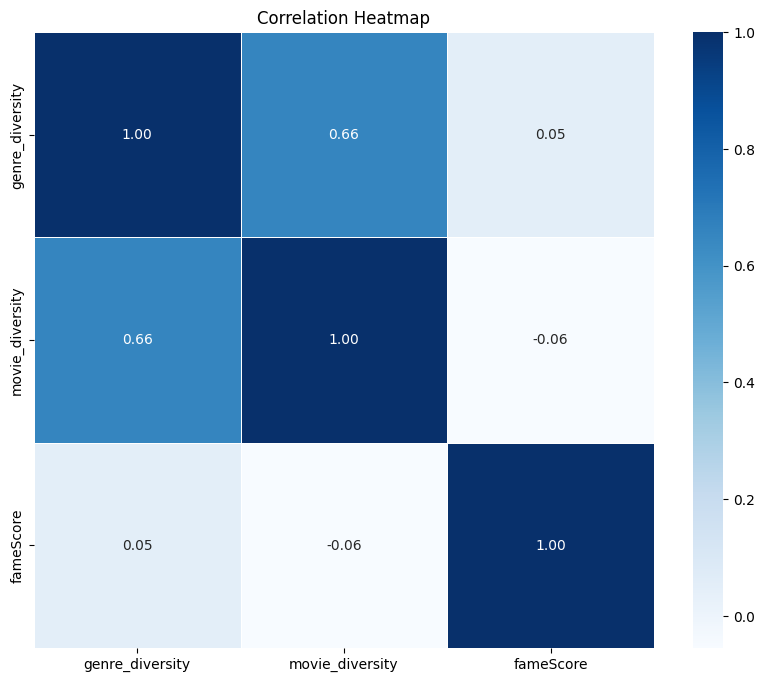

In [64]:
# Calculate the correlation matrix
correlation_matrix = actor_genres[['genre_diversity','movie_diversity','fameScore']]\
                              .corr(method='pearson')

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [65]:
actor_mean_n = actor_genres[['fameScore','movie_diversity','genre_diversity']].groupby(by=['movie_diversity','genre_diversity'],as_index=False).agg(['median','std','count']).reset_index()
actor_mean_n = actor_mean_n[actor_mean_n['fameScore']['count']>10]
actor_mean_n

movie_diversity genre_diversity fameScore                  
                                        median        std  count
0                  1               0  0.678270   0.970602    473
1                  1               1  1.124848   4.847157  15389
2                  1               2  1.606269   5.289146  18424
3                  1               3  3.831069  13.586469  73443
4                  2               0  0.717574   0.180168     11
...              ...             ...       ...        ...    ...
3273              81              19  0.956031   0.914314     12
3299              82              19  0.981085   1.319621     13
3323              83              19  0.979072   1.320789     13
3343              84              19  0.983639   1.364025     11
3365              85              19  1.042240   1.352791     11

[1312 rows x 5 columns]

In [66]:
fig = px.scatter(x=actor_mean_n['genre_diversity'], 
                 y=actor_mean_n['fameScore']['median'], 
                 animation_frame=actor_mean_n['movie_diversity'],
                 range_x=[0,50], range_y=[0,12],
                 #  error_y=mean_fame_diversity['fameScore']['std'],
                 labels={'y': 'Mean Value', 'animation_frame': 'number of movies played'})


# Reshape the figure by updating layout parameters
fig.update_layout(
    width=600,  # Set the width of the figure
    height=400,  # Set the height of the figure
    title='',  # Update the title
    xaxis_title='genre diversity',  # Update the X-axis label
    yaxis_title='median fame score',  # Update the Y-axis label
    margin=dict(l=50, r=50, b=50, t=50),  # Adjust margins if needed
)

fig.show()

In [67]:
fig = px.scatter(x=actor_mean_n['movie_diversity'], 
                 y=actor_mean_n['fameScore']['median'], 
                 animation_frame=actor_mean_n['genre_diversity'],
                 range_x=[0,70], range_y=[0,12],
                 #  error_y=mean_fame_diversity['fameScore']['std'],
                 labels={'y': 'Mean Value', 'animation_frame': 'genre diversity'})


# Reshape the figure by updating layout parameters
fig.update_layout(
    width=600,  # Set the width of the figure
    height=400,  # Set the height of the figure
    title='',  # Update the title
    xaxis_title='number of movies played',  # Update the X-axis label
    yaxis_title='median fame score',  # Update the Y-axis label
    margin=dict(l=50, r=50, b=50, t=50),  # Adjust margins if needed
)

fig.show()

In [70]:
mod = smf.ols(formula='fameScore ~ genre_diversity + movie_diversity', data=actor_genres)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              fameScore   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2940.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:35:05   Log-Likelihood:            -1.1812e+06
No. Observations:              331225   AIC:                         2.362e+06
Df Residuals:                  331222   BIC:                         2.362e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.0935      0.021    2

### 2.3 Persona Analysis

Initially, we discretize the age data into subsets to identify distinct clusters. Subsequently, we assign a group number to each cluster, taking into account factors such as ethnicity, gender, and age at the time of release.

In [49]:
cplt_character = cmu_character.dropna(subset=['actor_age_at_release','actor_ethnicity','actor_gender','persona']).copy()
bins=[0, 40, 60, 80, 100]
Ages = ['0-40','41-60','61-80','81-100']
cplt_character['actor_age_gr_at_release'] = pd.cut(cplt_character['actor_age_at_release'],bins=bins,labels=Ages)

cplt_character['group'] = cplt_character.groupby(by=['actor_age_gr_at_release','actor_ethnicity','actor_gender']).ngroup()
cplt_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,is_principal,persona,fameScore_before,fameScore,fameScore_diff,actor_age_gr_at_release,group
66,156558,/m/014k4y,Yvette,1970-09-11,F,1.650,"Black, Caribbean or African",Taraji P. Henson,30.0,/m/0jtx5t,/m/03jnxj_,/m/0blbxk,2001-06-27,0.0,46.0,1.303544,2.989530,1.685986,0-40,2.0
67,156558,/m/014k4y,Jody,1978-12-30,M,1.797,"Black, Caribbean or African",Tyrese Gibson,22.0,/m/0jtx5h,/m/03jnxf4,/m/01l1b90,2001-06-27,1.0,4.0,0.000000,9.657628,9.657628,0-40,3.0
85,156558,/m/014k4y,Rodney,1971-10-20,M,1.918,"Black, Caribbean or African",Snoop Dogg,29.0,/m/0jtx5n,/m/03jnx_2,/m/01vw8mh,2001-06-27,0.0,41.0,2.783077,3.309228,0.526152,0-40,3.0
98,156558,/m/014k4y,Melvin,1959-05-12,M,1.830,"Black, Caribbean or African",Ving Rhames,42.0,/m/03jnxct,/m/03jnxcx,/m/032zg9,2001-06-27,0.0,35.0,17.271506,16.849999,-0.421507,41-60,11.0
102,156558,/m/014k4y,Sweetpea,1976-10-19,M,1.829,"Black, Caribbean or African",Omar Gooding,24.0,/m/03jnxn4,/m/03jnxn7,/m/05cgxx,2001-06-27,1.0,40.0,0.910451,5.283977,4.373526,0-40,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331095,6456053,/m/0g605h,Paolo Maltese,1927-10-18,M,1.850,White,George C. Scott,37.0,/m/04p4q_p,/m/0hnw0l3,/m/0l786,1964-12-31,0.0,40.0,37.742232,32.491050,-5.251182,0-40,7.0
331101,6456053,/m/0g605h,Joey Friedlander,1918-11-04,M,1.770,White,Art Carney,46.0,/m/0cg660g,/m/0hnw0k2,/m/015qt5,1964-12-31,0.0,40.0,0.000000,6.260990,6.260990,41-60,15.0
331108,22330502,/m/05sync6,Yvonne Valbret,1905-09-18,F,1.702,White,Greta Garbo,25.0,/m/05tg4vb,/m/0h2ppfw,/m/0h14h,1931-01-31,0.0,49.0,8.188430,7.940898,-0.247532,0-40,6.0
331122,24997872,/m/09g6klx,Raja,1951-09-07,M,1.780,"Asian, Middle East and Tribes",Mammootty,58.0,/m/0gvytkx,/m/0h27wx_,/m/02hkv5,2010-05-07,1.0,40.0,0.807543,0.815547,0.008004,41-60,9.0


The following function is defined to determine the group of an actor based on their characteristics:

In [50]:
def find_group(gender,ethni,age):

    return cplt_character[(cplt_character['actor_gender'] == gender) & 
                (cplt_character['actor_age_gr_at_release'] == age) & 
                (cplt_character['actor_ethnicity'] == ethni)]['group'].unique()[0]

A function is then written to generate a plot illustrating the mean and standard deviation of the differential fame scores for a specified group of actors.

In [51]:
def plotall(cluster):
    actor_group = cplt_character[cplt_character['group'] == cluster]
    actor_group = actor_group.dropna(subset=['persona']).copy()
    actor_group['persona'] = actor_group['persona'].astype(int)

    actor_group = actor_group[['freebase_char_actor_map', 'fameScore_diff', 'persona']]

    persona_counts = actor_group.groupby('persona',as_index=False).agg('count')
    persona_counts = persona_counts[persona_counts['fameScore_diff']>10]

    actor_group = actor_group.merge(persona_counts['persona'],on='persona')

    actor_group_persona = actor_group[['persona','fameScore_diff']].groupby(by=['persona'],as_index=False).agg(['mean','std'])

    fig = px.scatter(actor_group_persona['fameScore_diff'], x=actor_group_persona.index, y='mean', error_y='std', title='Average Fame Scores with Variance Bars',
                 labels={'avg_fame_score': 'Average Fame Score', 'persona': 'Persona'})

    return fig

Lastly, an application is developed, allowing users to select a group of actors and assess whether a persona is more likely to yield a positive fame score differential or not.

In [52]:
Genders = cplt_character['actor_gender'].unique()
Ethnis = cplt_character['actor_ethnicity'].unique()
# Dash app
app = dash.Dash(__name__)

app.layout = html.Div([    # fameScore_diff = cplt_character[cplt_character['group']==n]['fameScore_diff']
    html.H1("Interactive Regression Coefficients Plot"),
    html.Div([
    # Dropdown to select cluster
    dcc.Dropdown(
        id='gender-selection',
        options=[
            {'label': str(gender), 'value': gender}
            for gender in Genders
        ],
        value=Genders[0],  # Set default value
        style={'width': '300px'}
    )], style={'display': 'inline-block', 'margin-right': '20px'}),

    html.Div([
    dcc.Dropdown(
        id='ethni-selection',
        options=[
            {'label': str(ethni), 'value': ethni}
            for ethni in Ethnis
        ],
        value=Ethnis[0],  # Set default value
        style={'width': '300px'}
    )], style={'display': 'inline-block', 'margin-right': '20px'}),

    html.Div([
    dcc.Dropdown(
        id='age-selection',
        options=[
            {'label': str(age), 'value': age}
            for age in Ages
        ],
        value=Ages[0],  # Set default value
        style={'width': '300px'}
    )], style={'display': 'inline-block', 'margin-right': '20px'}),
    
    # Graph to display coefficients
    dcc.Graph(id='coefficients-graph')
])

# Callback to update graph based on cluster selection
@app.callback(
    Output('coefficients-graph', 'figure'),
    [Input('gender-selection', 'value'),
     Input('ethni-selection', 'value'),
     Input('age-selection', 'value')]
)
def update_graph(gender,ethni,age):
    cluster = cplt_character[(cplt_character['actor_gender'] == gender) & 
                (cplt_character['actor_age_gr_at_release'] == age) & 
                (cplt_character['actor_ethnicity'] == ethni)]['group'].unique()[0]
    return plotall(cluster)

if __name__ == '__main__':
    app.run_server(debug=True, port=8052)


In the presented analysis, it's evident that none of the personas exhibits a discernible impact on the fameScore_diff. To investigate further into the potential correlation between fameScore_diff and persona within a particular group of actors, we opt to conduct an ANOVA test. This statistical test will help us determine whether there are significant differences in the fameScore_diff among the various personas within the chosen actor group.

In [53]:
n = 5
fameScore_diff = cplt_character[cplt_character['group']==n]['fameScore_diff']
persona = cplt_character[cplt_character['group']==n][['persona']]
persona_counts = persona.value_counts().to_frame().reset_index()
persona_counts = persona_counts[persona_counts['count']>10]

select_lines = persona['persona'].isin(persona_counts['persona'])
persona = persona[select_lines]['persona']
fameScore_diff = fameScore_diff[select_lines]

f_statistic, p_value = f_oneway(*[fameScore_diff[persona == category] for category in persona.unique()])

print(f'f_statistic : {f_statistic}')
print(f'p_value : {p_value}')

f_statistic : 1.3085212501454477
p_value : 0.16434649563139542


We notice that, for numerous actor groups, the null hypothesis cannot be rejected. Therefore, it can be assumed that the selection of a persona does not exert an influence on whether there is an increase in fameScore or not.

### 2.6 Country Analysis

In this part we'll try to answer the following question : **Is there a better country to play in ?**

The primary goal is to assess the fame scores across major film-producing nations. We will focus on the top five countries with the highest popularity ratings from the provided database

In [80]:
actor_country= cmu_character[['wikiID','actor_name','freebase_actorID','fameScore','release_date','actor_ethnicity']] \
                            .merge(cmu_movies[['wikiID','country']])
actor_country['country'] = actor_country['country'].apply(lambda x: x[0] if len(x) != 0 else None )

In [81]:
main_countries = actor_country[['country','wikiID']].groupby(by=['country'],as_index=False).agg('count').sort_values(by=['wikiID'],ascending=False).head(5)
actor_country = actor_country.merge(main_countries['country'],on=['country'])
main_countries

,country,wikiID
104,United States of America,199917
41,India,30776
103,United Kingdom,19602
33,France,16248
49,Japan,6665


In [82]:
median_country = actor_country[['country','fameScore']].groupby(by=['country'],as_index=False).agg('median')

actor_country['release_date']=pd.to_datetime(actor_country['release_date']).dt.year
bins = range(actor_country['release_date'].min(),actor_country['release_date'].max() + 6, 5)
actor_country['release_date']= pd.cut(actor_country['release_date'], bins=bins, labels=bins[:-1])
actor_country['release_date'] = pd.to_numeric(actor_country['release_date'], errors='coerce')

In [83]:
fig = px.bar(
    median_country,
    x='country',
    y='fameScore',
    labels={'fameScore': 'Median Fame Score'},
    title='Median Fame Score by Country',
)

# Update layout parameters
fig.update_layout(
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=50, t=50),
    xaxis_title='Country',
    yaxis_title='Median Fame Score',
)

fig.show()

It is evident that the median fame score is consistently higher in the epicenter of the film industry ('USA'), whereas it is notably low in India.

We believe that actor ethnicity is highly correlated with the country of the movie. Conducting a chi-square analysis could provide evidence supporting this hypothesis.



In [87]:
# Calculate the correlation matrix
contingency_table = pd.crosstab(actor_country['country'], actor_country['actor_ethnicity'])

# Perform the chi-squared test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f'chi2 : {chi2}')
print(f'p_value : {p_value}')

# Create a Plotly Heatmap
fig = go.Figure(go.Heatmap(
    z=contingency_table.values,
    x=contingency_table.columns,
    y=contingency_table.index,
    colorscale='Blues',
    colorbar=dict(title='Count'),
    zmin=0,
    zmax=contingency_table.max().max(),
))

# Add annotations
for i in range(len(contingency_table.index)):
    for j in range(len(contingency_table.columns)):
        fig.add_annotation(
            x=contingency_table.columns[j],
            y=contingency_table.index[i],
            text=str(contingency_table.iloc[i, j]),
            showarrow=False,
            font=dict(color='white' if contingency_table.iloc[i, j] > contingency_table.max().max() / 2 else 'black')
        )

# Update layout parameters
fig.update_layout(
    title='Correlation Heatmap',
    xaxis=dict(title='country'),
    yaxis=dict(title='actor_ethnicity'),
)

fig.show()

chi2 : 39468.339359026504
p_value : 0.0


Therefore, our observation suggests that only Asian individuals are likely to be cast in Indian movies, whereas the diversity in the USA is much broader. Now, we aim to understand whether the low fame score is attributed to the Indian ethnicity of the actor or if it is primarily influenced by the country of origin of the movie.

For this reason, we are plotting the median fame score by country specifically for individuals of Asian ethnicity.

In [90]:
median_country = actor_country[['country','fameScore','actor_ethnicity']].groupby(by=['actor_ethnicity','country'],as_index=False).agg('median')
median_country = median_country[median_country['actor_ethnicity']=='Asian, Middle East and Tribes']
median_country
# Create a line plot
fig = px.bar(
    median_country,
    x='country',  # Assuming release_date is in a datetime format
    y='fameScore',
    labels={'fameScore': 'Fame Score'},
    title='Fame Score Over Time by Country for Asian ethnicity',
)

# Update layout parameters
fig.update_layout(
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=50, t=50),
    xaxis_title='Release Date',
    yaxis_title='median Fame Score',
)

fig.show()

It appears that even for individuals of Asian ethnicity, the advantages in terms of fame score are more pronounced when they are cast in movies produced in the USA.

This observation could be open to discussion based on the origin of the data and the methodology used to compute the fame score. Given that the IMDb dataset was created in the USA, it is plausible to assume that a significant portion of the ratings comes from American or European audiences. Consequently, a tentative conclusion is that, for optimal fame scores among American audiences, an actor may find it beneficial to participate in productions based in the USA or Europe. However, further analysis and considerations may be needed to validate and refine this conclusion.

#### Does these conclusions constant in time ?

In [91]:
median_country = actor_country[['country','fameScore','release_date']].groupby(by=['release_date','country'],as_index=False).agg('median')
median_country

# Create a line plot
fig = px.line(
    median_country,
    x='release_date',  # Assuming release_date is in a datetime format
    y='fameScore',
    color='country',
    labels={'fameScore': 'Fame Score'},
    title='Fame Score Over Time by Country',
)

# Update layout parameters
fig.update_layout(
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=50, t=50),
    xaxis_title='Release Date',
    yaxis_title='Median Fame Score',
)

fig.show()

It's interesting to note that for older dates, data limitations may affect the analysis due to insufficient information. On the other hand, when examining more recent data, there doesn't seem to be any discernible change over time. This stability in patterns could suggest a consistent trend in the relationship between actor location and fame scores, emphasizing the enduring influence of factors like movie origin on audience recognition.

In [92]:
limit_year = 1980
actor_country = actor_country[actor_country['release_date']>limit_year]
median_country = median_country[median_country['release_date']>limit_year]
# Create a line plot
fig = px.line(
    median_country,
    x='release_date',  # Assuming release_date is in a datetime format
    y='fameScore',
    color='country',
    labels={'fameScore': 'Fame Score'},
    title='Fame Score Over Time by Country',
)

# Update layout parameters
fig.update_layout(
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=50, t=50),
    xaxis_title='Release Date',
    yaxis_title='Fame Score',
)

fig.show()